### Importing libraries

In [50]:
import pandas as pd
import numpy as np
import glob

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, accuracy_score, classification_report, roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.pipeline import make_pipeline
import matplotlib.pyplot as plt
from itertools import cycle


### Data preprocessing

In [3]:
df = pd.read_csv('combined.csv')
df

,Package Name,App Version Code,App Version Name,Reviewer Language,Device,Review Submit Date and Time,Review Submit Millis Since Epoch,Review Last Update Date and Time,Review Last Update Millis Since Epoch,Star Rating,Review Title,Review Text,Developer Reply Date and Time,Developer Reply Millis Since Epoch,Developer Reply Text,Review Link
0,com.nick.memasik,NaN,NaN,es,surnia_umts,2018-12-01T00:00:54Z,1543622454139,2018-12-01T00:00:54Z,1543622454139,5,NaN,NaN,NaN,NaN,NaN,NaN
1,com.nick.memasik,95.0,3.0.1,es,cs02ve3gss,2018-12-01T00:25:28Z,1543623928849,2018-12-01T00:25:49Z,1543623949604,3,NaN,Ehhh.......,NaN,NaN,NaN,http://play.google.com/console/developers/4768...
2,com.nick.memasik,95.0,3.0.1,es,j7xelte,2018-12-01T02:30:39Z,1543631439053,2018-12-01T02:32:07Z,1543631527535,5,NaN,Esta aplicación esta padrisima ojala que asi f...,NaN,NaN,NaN,http://play.google.com/console/developers/4768...
3,com.nick.memasik,95.0,3.0.1,es,E1M,2018-12-01T02:40:37Z,1543632037870,2018-12-01T02:41:12Z,1543632072218,5,NaN,Muy divertida,NaN,NaN,NaN,http://play.google.com/console/developers/4768...
4,com.nick.memasik,95.0,3.0.1,es,judyln,2018-12-01T03:12:48Z,1543633968769,2018-12-01T03:12:55Z,1543633975304,5,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62370,com.nick.memasik,NaN,NaN,ar,hwY635,2018-09-30T21:12:47Z,1538341967638,2018-09-30T21:12:52Z,1538341972314,3,NaN,NaN,NaN,NaN,NaN,NaN
62371,com.nick.memasik,90.0,2.1,es,grandprimevelteltn,2018-09-30T21:43:03Z,1538343783391,2018-09-30T21:43:25Z,1538343805498,1,NaN,Es un ascoo,NaN,NaN,NaN,http://play.google.com/console/developers/4768...
62372,com.nick.memasik,90.0,2.1,es,a5xelte,2018-09-30T22:03:41Z,1538345021089,2018-09-30T22:03:41Z,1538345021089,3,NaN,NaN,NaN,NaN,NaN,NaN
62373,com.nick.memasik,90.0,2.1,es,hwG610-U15,2018-09-30T22:29:47Z,1538346587066,2018-09-30T22:30:26Z,1538346626461,5,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
# Define your criteria (replace 'column_name' and 'desired_value' with your actual column and value)
criteria = (df['Reviewer Language'] == 'en')

# Use the criteria to filter the DataFrame
df_eng = df[criteria]

In [5]:
selected_columns = ['Review Text','Star Rating']
df_class = df_eng[selected_columns]
df_class

,Review Text,Star Rating
57,I luv memes,4
60,NaN,4
79,NaN,4
85,This is the best app i love it,5
94,Good now I can make my own meme,5
...,...,...
62206,NaN,5
62236,I hate it,1
62255,NaN,4
62266,I love this app,5


### Dropping NaN values

In [6]:
df_class.dropna(subset=['Review Text'], inplace=True)
df_class.shape

/var/folders/wc/9nczhhns0gx_03t4t5yv_z580000gn/T/ipykernel_8111/2434299613.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_class.dropna(subset=['Review Text'], inplace=True)


(3365, 2)

In [7]:
missing_values_per_column = df_class.isnull().sum()
missing_values_per_column


Review Text    0
Star Rating    0
dtype: int64

In [8]:
column_mapping = {
    'Review Text': 'reviews',
    'Star Rating': 'target'
}

df_class = df_class.rename(columns=column_mapping)


### A quick look at the data

In [9]:
df_class.sample(10)

,reviews,target
43660,It's so funny 😂😂😂😂😂😂,5
23440,I like it but the meme coins are quite annoyin...,3
11212,It wont let me download the free packs to make...,4
10617,I love it its just like instagram and face boo...,5
22917,It was awesome,5
36359,A lot of hate and people getting bullied and c...,1
22225,Nice,5
17604,I want some change,4
26233,Great for talking.,5
5764,"I originally loved this app, people were kind ...",1


In [10]:
print("Dataset contains {} instances of {} variables.".format(df_class.shape[0], df_class.shape[1]))

print(
    "It contains {} 1 star reviews ({:.1%} of all).".format(
        df_class[df_class.target == 1].shape[0],
        df_class[df_class.target == 1].shape[0] / df_class.shape[0],
    )
)

print(
    "It contains {} 2 star reviews ({:.1%} of all).".format(
        df_class[df_class.target == 2].shape[0],
        df_class[df_class.target == 2].shape[0] / df_class.shape[0],
    )
)

print(
    "It contains {} 3 star reviews ({:.1%} of all).".format(
        df_class[df_class.target == 3].shape[0],
        df_class[df_class.target == 3].shape[0] / df_class.shape[0],
    )
)

print(
    "It contains {} 4 star reviews ({:.1%} of all).".format(
        df_class[df_class.target == 4].shape[0],
        df_class[df_class.target == 4].shape[0] / df_class.shape[0],
    )
)
print(
    "It contains {} 5 star reviews ({:.1%} of all).".format(
        df_class[df_class.target == 5].shape[0],
        df_class[df_class.target == 5].shape[0] / df_class.shape[0],
    )
)

Dataset contains 3365 instances of 2 variables.
It contains 361 1 star reviews (10.7% of all).
It contains 75 2 star reviews (2.2% of all).
It contains 136 3 star reviews (4.0% of all).
It contains 266 4 star reviews (7.9% of all).
It contains 2527 5 star reviews (75.1% of all).


In [11]:
## Printing random samples of text from both the classes i.e. 1 star and 
print(
    "Examples of negative review: \n    {}\n    {}".format(
        df_class[df_class.target == 1].sample(1).reviews.iloc[0],
        df_class[df_class.target == 1].sample(1).reviews.iloc[0],
    )
)
print(
    "\nExamples of positive review: \n    {}\n    {}".format(
        df_class[df_class.target == 5].sample(1).reviews.iloc[0],
        df_class[df_class.target == 5].sample(1).reviews.iloc[0],
    )
)

Examples of negative review: 
    It has a hacker
    Hard to use and very buggy

Examples of positive review: 
    I COULDNT LOGIN FIVE TIMES AND MY LAST REVIEW WAS DELETED PLEASE FIX THIS ALTOUGH ITS GOOD
    BEST THING EVER


### Multiclassification

In [12]:
# Split dataset between train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    df_class["reviews"], df_class["target"], test_size=0.2, random_state=42
)

In [13]:
y_train.head()

45858    5
11756    5
57603    5
14904    1
17128    5
Name: target, dtype: int64

### CountVectorizer

Transforming the text so that each word is a separate feature. Converting our text into sparse matrix.

In [14]:
# Fit the CountVectorizer to the training data
vect = CountVectorizer().fit(X_train)

# transform the documents in the training data to a document-term matrix
X_train_vectorized = vect.transform(X_train)
# print("X_train_vectorized: ", X_train_vectorized)

In [15]:
print("X_train shape = {}".format(X_train.shape))
print("Vocabulary length = {}".format(len(vect.vocabulary_)))

X_train shape = (2692,)
Vocabulary length = 2931


So in 2523 reviews CountVectorizer found 2791 different words.

In [16]:
# Let's look at our vocabulary list (sorted alphabetically)
# Does it look like you expected?
sorted(vect.vocabulary_.items(), key=lambda x: x[1])[1300:1335]

[('jackintheblox', 1300),
 ('jailbreak', 1301),
 ('jam', 1302),
 ('jan', 1303),
 ('jane', 1304),
 ('jangan', 1305),
 ('jejejeje', 1306),
 ('jest', 1307),
 ('jiffy', 1308),
 ('jimtheantifurry', 1309),
 ('jisne', 1310),
 ('jk', 1311),
 ('jo', 1312),
 ('job', 1313),
 ('joe', 1314),
 ('jog', 1315),
 ('john', 1316),
 ('join', 1317),
 ('jojo', 1318),
 ('joke', 1319),
 ('jokeeee', 1320),
 ('jokes', 1321),
 ('joy', 1322),
 ('jsabmaker', 1323),
 ('judged', 1324),
 ('july', 1325),
 ('jus', 1326),
 ('just', 1327),
 ('justthinkguyyt', 1328),
 ('juvenile', 1329),
 ('karte', 1330),
 ('kat123k', 1331),
 ('katai', 1332),
 ('kayo', 1333),
 ('keep', 1334)]

In [17]:
# with .toarray() the compressed sparse matrix form is converted to a normal numpy array
print(X_train_vectorized.toarray())

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


### Bulding pipeline with vectorized data and Logistic regression

In [18]:
# Create a pipeline with CountVectorizer and Logistic Regression

model = make_pipeline(CountVectorizer(), LogisticRegression(max_iter=1000))

In [19]:
# Train the model
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

# Print classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

Accuracy: 0.78
Classification Report:
              precision    recall  f1-score   support

           1       0.56      0.52      0.54        62
           2       0.25      0.05      0.09        19
           3       0.17      0.10      0.13        29
           4       0.60      0.18      0.28        66
           5       0.83      0.96      0.89       497

    accuracy                           0.78       673
   macro avg       0.48      0.36      0.38       673
weighted avg       0.74      0.78      0.74       673



In [20]:
# Binarize the labels for each class
y_test_bin = label_binarize(y_test, classes=[1, 2, 3, 4, 5])

# Predict probabilities for each class
y_pred_prob = model.predict_proba(X_test)

# Calculate AUC-ROC for each class
auc_scores = []
for i in range(5):  # Assuming 5 classes
    auc = roc_auc_score(y_test_bin[:, i], y_pred_prob[:, i])
    auc_scores.append(auc)
    print(f"AUC-ROC for Class {i + 1}: {auc:.2f}")

# You can also calculate the average AUC-ROC across all classes
average_auc = sum(auc_scores) / len(auc_scores)
print(f"\nAverage AUC-ROC: {average_auc:.2f}")

AUC-ROC for Class 1: 0.91
AUC-ROC for Class 2: 0.83
AUC-ROC for Class 3: 0.78
AUC-ROC for Class 4: 0.71
AUC-ROC for Class 5: 0.86

Average AUC-ROC: 0.82


In [21]:
# Get the feature names from the CountVectorizer
feature_names = model.named_steps['countvectorizer'].get_feature_names_out()

# Get the coefficients from the trained Logistic Regression model
coefficients = model.named_steps['logisticregression'].coef_

# Create a DataFrame to associate feature names with their coefficients
coef_df = pd.DataFrame(data=coefficients[0], index=feature_names, columns=['Coefficient'])

# Sort the DataFrame to see words with the highest and lowest coefficients
top_words = coef_df.sort_values(by='Coefficient', ascending=False).head(10)
bottom_words = coef_df.sort_values(by='Coefficient', ascending=True).head(10)

print("Top 10 words with highest coefficients:")
print(top_words)

print("\nTop 10 words with lowest coefficients:")
print(bottom_words)


Top 10 words with highest coefficients:
             Coefficient
worst           1.818223
hate            1.707257
garbage         1.511657
sucks           1.430717
useless         1.430051
waste           1.229657
isn             1.183869
save            1.142975
stupid          1.134883
application     1.113925

Top 10 words with lowest coefficients:
       Coefficient
nice     -1.344020
good     -1.342794
love     -1.260383
best     -1.181174
cool     -1.103045
great    -1.092224
like     -1.013085
but      -1.007470
fun      -0.991331
funny    -0.989366


### TF-IDF

In [22]:
# Fit the TfidfVectorizer to the training data specifiying a minimum document frequency of 15
# This means a word should have been used in at least 15 SMS 
vect = TfidfVectorizer(min_df=1).fit(X_train)

# transform the documents in the training data to a document-term matrix
X_train_vectorized = vect.transform(X_train)

# let's look of some of the words gathered with this method
sorted(vect.vocabulary_.items(), key=lambda x: x[1])[2310:2330]

[('stonks', 2310),
 ('stoot', 2311),
 ('stop', 2312),
 ('stopped', 2313),
 ('stops', 2314),
 ('storage', 2315),
 ('store', 2316),
 ('straight', 2317),
 ('stream', 2318),
 ('stress', 2319),
 ('stuck', 2320),
 ('stucks', 2321),
 ('stuff', 2322),
 ('stupid', 2323),
 ('stupidest', 2324),
 ('style', 2325),
 ('styles', 2326),
 ('sub', 2327),
 ('subs', 2328),
 ('subscrib', 2329)]

In [23]:
# how many words appear in more than 15 text messages
len(sorted(vect.vocabulary_.items(), key=lambda x: x[1]))

2931

In [24]:
model = make_pipeline(TfidfVectorizer(), LogisticRegression(max_iter=1000))

In [25]:
# Train the model
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

# Print classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

Accuracy: 0.76
Classification Report:
              precision    recall  f1-score   support

           1       0.59      0.37      0.46        62
           2       0.00      0.00      0.00        19
           3       0.00      0.00      0.00        29
           4       0.14      0.02      0.03        66
           5       0.78      0.98      0.87       497

    accuracy                           0.76       673
   macro avg       0.30      0.27      0.27       673
weighted avg       0.64      0.76      0.69       673



/Users/mac/.pyenv/versions/3.11.3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mac/.pyenv/versions/3.11.3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/mac/.pyenv/versions/3.11.3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(resu

In [26]:
# Binarize the labels for each class
y_test_bin = label_binarize(y_test, classes=[1, 2, 3, 4, 5])

# Predict probabilities for each class
y_pred_prob = model.predict_proba(X_test)

# Calculate AUC-ROC for each class
auc_scores = []
for i in range(5):  # Assuming 5 classes
    auc = roc_auc_score(y_test_bin[:, i], y_pred_prob[:, i])
    auc_scores.append(auc)
    print(f"AUC-ROC for Class {i + 1}: {auc:.2f}")

# You can also calculate the average AUC-ROC across all classes
average_auc = sum(auc_scores) / len(auc_scores)
print(f"\nAverage AUC-ROC: {average_auc:.2f}")

AUC-ROC for Class 1: 0.92
AUC-ROC for Class 2: 0.91
AUC-ROC for Class 3: 0.82
AUC-ROC for Class 4: 0.72
AUC-ROC for Class 5: 0.87

Average AUC-ROC: 0.85


In [27]:
# save all feature names == words in an array
feature_names = np.array(vect.get_feature_names_out())

#sort for the column names according to highest tfidf value in the column
sorted_tfidf_index = X_train_vectorized.toarray().max(0).argsort()

# print words with highest and lowest tfidf values
print("Smallest tfidf:\n{}\n".format(feature_names[sorted_tfidf_index[:10]]))
print("Largest tfidf: \n{}".format(feature_names[sorted_tfidf_index[:-11:-1]]))

Smallest tfidf:
['𝚝𝚑𝚎' '𝙾𝚃𝙷𝙴𝚁' '𝙾𝙽𝙴' '𝙾𝙽' '𝙻𝙸𝚃𝙴𝚁𝙰𝙻𝙻𝚈' '𝙸𝙽' '𝙵𝚄𝙲𝙺' '𝙿𝙸𝙲𝚃𝚄𝚁𝙴𝚂' '𝙴𝚅𝙴𝙽'
 '𝙲𝙾𝙽𝙽𝙴𝙲𝚃']

Largest tfidf: 
['osam' 'bekar' 'yeeeey' 'lo' 'yaiy' 'sheesh' 'xd' 'wut' 'wunderbar'
 'good']


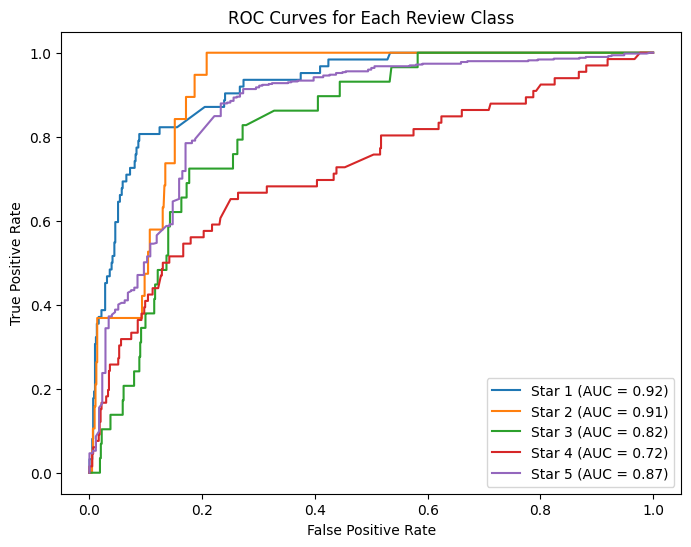

In [49]:
# Binarize the labels for each class
y_test_bin = label_binarize(y_test, classes=[1, 2, 3, 4, 5])

# Get the predicted probabilities for each class
y_pred_prob = model.predict_proba(X_test)

# Plot ROC curves for each class
plt.figure(figsize=(8, 6))

# Assuming 5 classes (stars from 1 to 5)
for i in range(5):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_pred_prob[:, i])
    roc_auc = auc(fpr, tpr)
    
    plt.plot(fpr, tpr, label=f'Star {i + 1} (AUC = {roc_auc:.2f})')

plt.title('ROC Curves for Each Review Class')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()